import all the necessary libraries

In [22]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, roc_auc_score, recall_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Set random seed for reproducibility

In [23]:
np.random.seed(42)

Load and Explore Dataset

In [24]:
#Step 1: Load and Explore Dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # 0: malignant, 1: benign

Print the dataset info

In [25]:
# Print dataset info
print("Dataset Info:")
print(X.info())
print("\nClass Distribution:")
print(pd.Series(y).value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness e

Visualise feature correlations

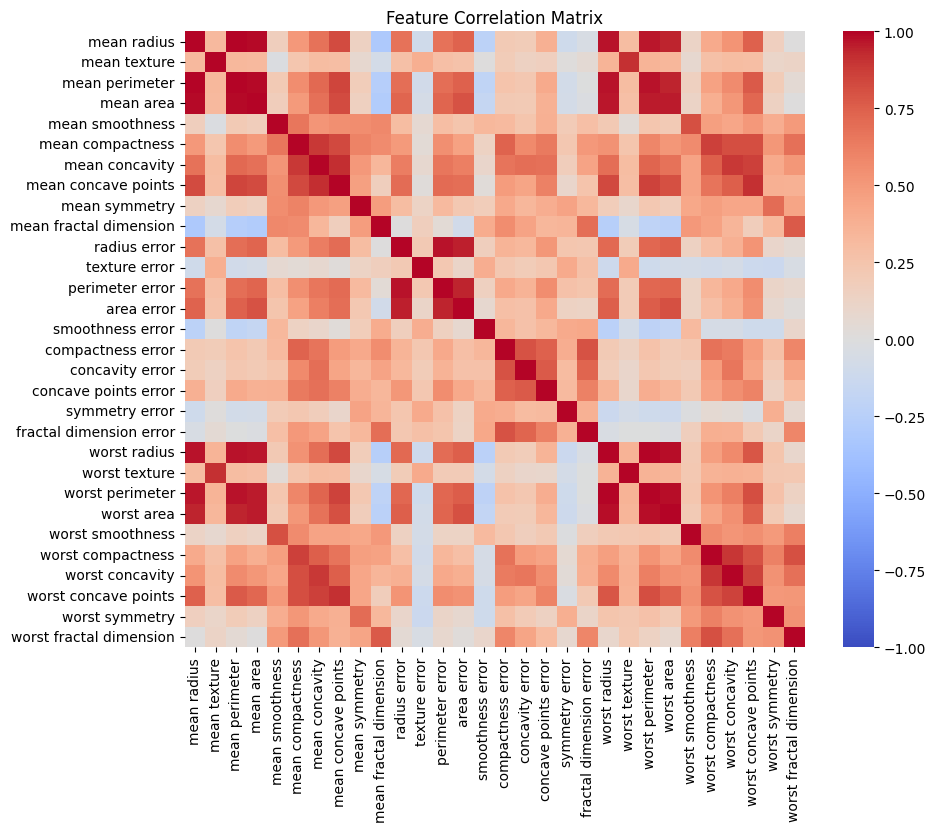

In [26]:
# Visualize feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

feature Engineering

In [27]:
# Step 2: Feature Engineering
# a. Feature Selection using Random Forest
rf_selector = RandomForestClassifier(random_state=42, n_estimators=100)
rf_selector.fit(X, y)
selector = SelectFromModel(rf_selector, prefit=True, threshold='median')
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected Features:", selected_features)


Selected Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


C:\Users\byamugisha octavious\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Add Polynomial Features (degree 2) for selected features

In [28]:
#b. Add Polynomial Features (degree 2) for selected features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[selected_features])
poly_feature_names = poly.get_feature_names_out(selected_features)
X = pd.DataFrame(X_poly, columns=poly_feature_names)

split the data

In [29]:
#Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 Step 4: Apply SMOTE to Training Data

In [30]:
#Step 4: Apply SMOTE to Training Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Visualize class distribution before and after SMOTE

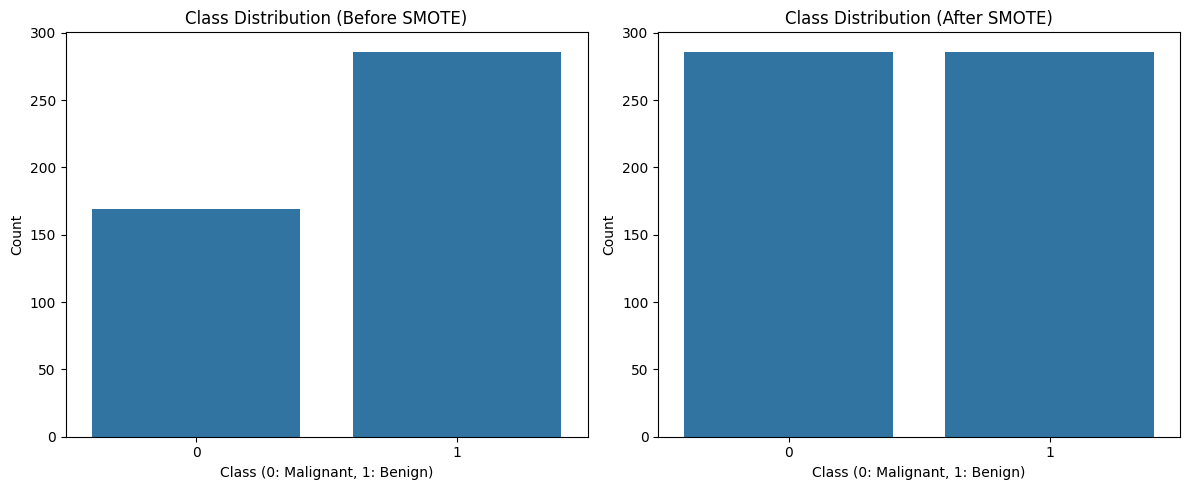

In [31]:
#Visualize class distribution before and after SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class Distribution (Before SMOTE)')
plt.xlabel('Class (0: Malignant, 1: Benign)')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('Class Distribution (After SMOTE)')
plt.xlabel('Class (0: Malignant, 1: Benign)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Define the pipelines with ensemble models

In [32]:
# Step 5: Define Pipelines with Ensemble Models
pipelines = {
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),  # For polynomial features and consistency
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ]),
    'Stacking': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
                ('svm', SVC(probability=True, random_state=42))
            ],
            final_estimator=LogisticRegression(random_state=42)
        ))
    ])
}

Train

In [33]:
#Step 6: Train, Cross-Validate, and Evaluate Models
results = {}
model_scores = {}
plt.figure(figsize=(8, 6))
for name, pipeline in pipelines.items():
    # Train model
    pipeline.fit(X_train_smote, y_train_smote)

C:\Users\byamugisha octavious\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [07:14:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 800x600 with 0 Axes>

Cross-validation (5-fold, ROC-AUC)

In [34]:
# Cross-validation (5-fold, ROC-AUC)
cv_scores = cross_val_score(pipeline, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
print(f"\n{name} 5-Fold Cross-Validation ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")



Stacking 5-Fold Cross-Validation ROC-AUC: 0.995 ± 0.004


 Test set predictions

In [35]:
y_pred = pipeline.predict(X_test)              # Get predicted class labels (0 or 1)
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get predicted probabilities for class 1 (malignant)


Store the results and scores

In [36]:
results[name] = {'y_pred': y_pred, 'y_prob': y_prob}
model_scores[name] = {
    'recall': recall_score(y_test, y_pred, pos_label=0),  # Recall for malignant class
    'roc_auc': roc_auc_score(y_test, y_prob),
    'cv_roc_auc': cv_scores.mean()
}


Classification report

In [37]:


# Print classification report
print(f"\n{name} Test Set Performance:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))



Stacking Test Set Performance:
              precision    recall  f1-score   support

   Malignant       0.95      0.95      0.95        43
      Benign       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



ROC CURVE

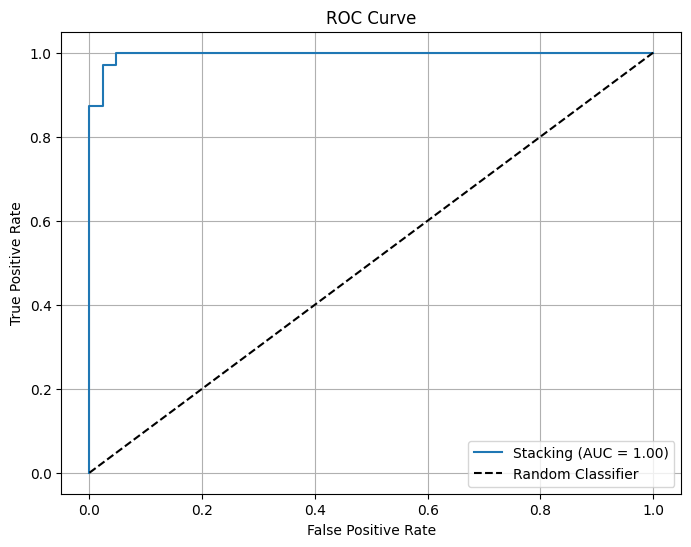

In [38]:


# Calculate false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Visualize Confusion Matrix for All Models

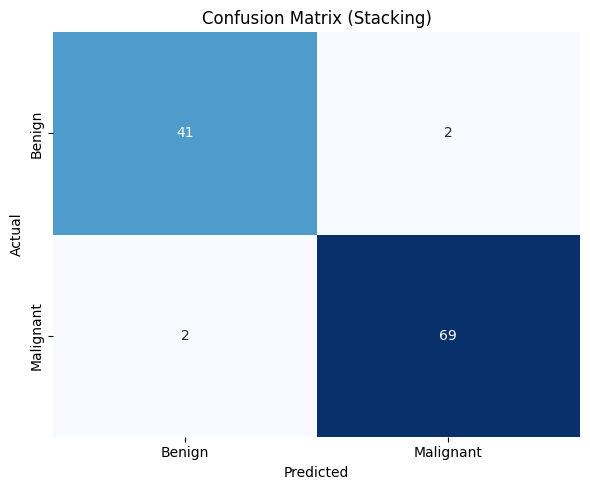

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

for name in pipelines:
    if name in results:
        cm = confusion_matrix(y_test, results[name]['y_pred'])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix ({name})')
        plt.tight_layout()
        plt.show()


Feature Importance for Random Forest

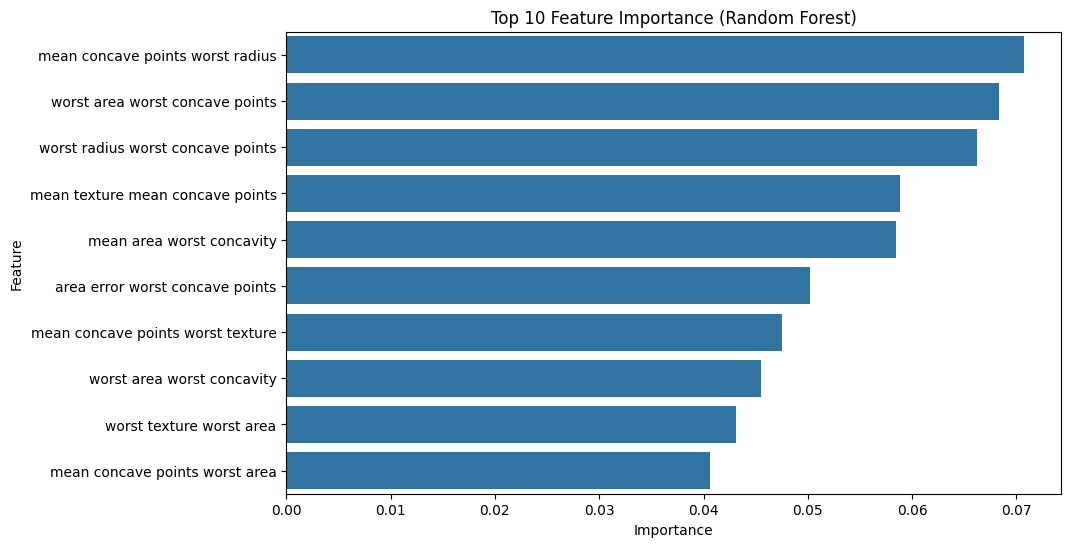

In [40]:
rf_pipeline = pipelines['Random Forest']
rf_model = rf_pipeline.named_steps['classifier']
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

 Model Selection

In [41]:
import joblib

print("\nModel Selection:")
best_model_name = max(model_scores, key=lambda name: (model_scores[name]['recall'], model_scores[name]['roc_auc']))
best_model = pipelines[best_model_name]
print(f"Best Model: {best_model_name}")
print(f"Recall (Malignant): {model_scores[best_model_name]['recall']:.3f}")
print(f"Test ROC-AUC: {model_scores[best_model_name]['roc_auc']:.3f}")
print(f"Cross-Validation ROC-AUC: {model_scores[best_model_name]['cv_roc_auc']:.3f}")
print("Selected based on highest recall for malignant class and ROC-AUC.")

# Step 10: Save the Best Model
joblib.dump(best_model, 'best_breast_cancer_model.pkl')
print(f"\nBest model ({best_model_name}) saved as 'best_breast_cancer_model.pkl'.")



Model Selection:
Best Model: Stacking
Recall (Malignant): 0.953
Test ROC-AUC: 0.996
Cross-Validation ROC-AUC: 0.995
Selected based on highest recall for malignant class and ROC-AUC.

Best model (Stacking) saved as 'best_breast_cancer_model.pkl'.


Save the Best Model

In [42]:
joblib.dump(best_model, 'best_breast_cancer_model.pkl')
print(f"\nBest model ({best_model_name}) saved as 'best_breast_cancer_model.pkl'.")



Best model (Stacking) saved as 'best_breast_cancer_model.pkl'.
